# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [4]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Tue Dec 12 12:57:00 2023


['Intan Input (1)/PortB L Aud Ctx',
 'Intan Input (1)/PortB L Vis Ctx',
 'Intan Input (1)/PortB L Hipp',
 'Intan Input (1)/PortB L Barrel',
 'Intan Input (1)/PortB L Motor',
 'Intan Input (1)/PortB R Motor',
 'Intan Input (1)/PortB R Barrel',
 'Intan Input (1)/PortB R Hipp',
 'Intan Input (1)/PortB R Vis Ctx',
 'Intan Input (1)/PortB R Aud Ctx']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
# cluster_window = SLURMCluster(
#         cores=8,
#         memory='20GB',
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_window.scale(jobs=15)  # Scale to 16 workers
# display(cluster_window)
# cluster_window.wait_for_workers(15)

In [8]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(10)
# display(cluster_spike)
# cluster_spike.wait_for_workers(10)

In [9]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [10]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    # with Client(LocalCluster()) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
    #     war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(LocalCluster()) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-21 23:01:42,537 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


In [ ]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

2025-03-21 23:01:42,685 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,686 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,687 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,688 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,688 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,689 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,689 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:42,693 - WARNING - Intan

In [12]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73863, 199.99384, 3...","[98233.96, 14860.108, 7970.6455, 37275.63, 151...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2990.8171, 9656.856, 4898.069, 6713.2295, 427...","{'delta': [2371.017, 3296.126, 1211.0659, 2644...","[(-1.6245375548094994, 3.0368814205586463), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98205, 98.85395, 73.50662, 72.37029, 407.4...","[1154.7555, 9768.596, 5399.9824, 5234.5786, 16...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.85815, 8765.923, 4538.3516, 4057.7214, 14...","{'delta': [190.04459, 1800.4429, 548.10364, 11...","[(-1.2709592689560614, 2.4014942712763423), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47052, 100.149216, 70.8411, 86.555595, 620...","[1557.7693, 10023.685, 5018.3926, 7481.013, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.93463, 7760.562, 3900.8845, 4248.7896, 79...","{'delta': [306.9735, 2821.0764, 938.7143, 2116...","[(-1.4739850325245956, 2.662434533055389), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


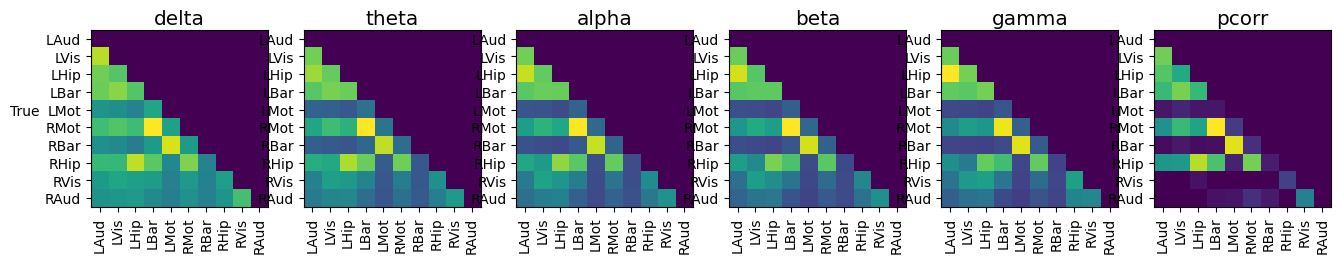

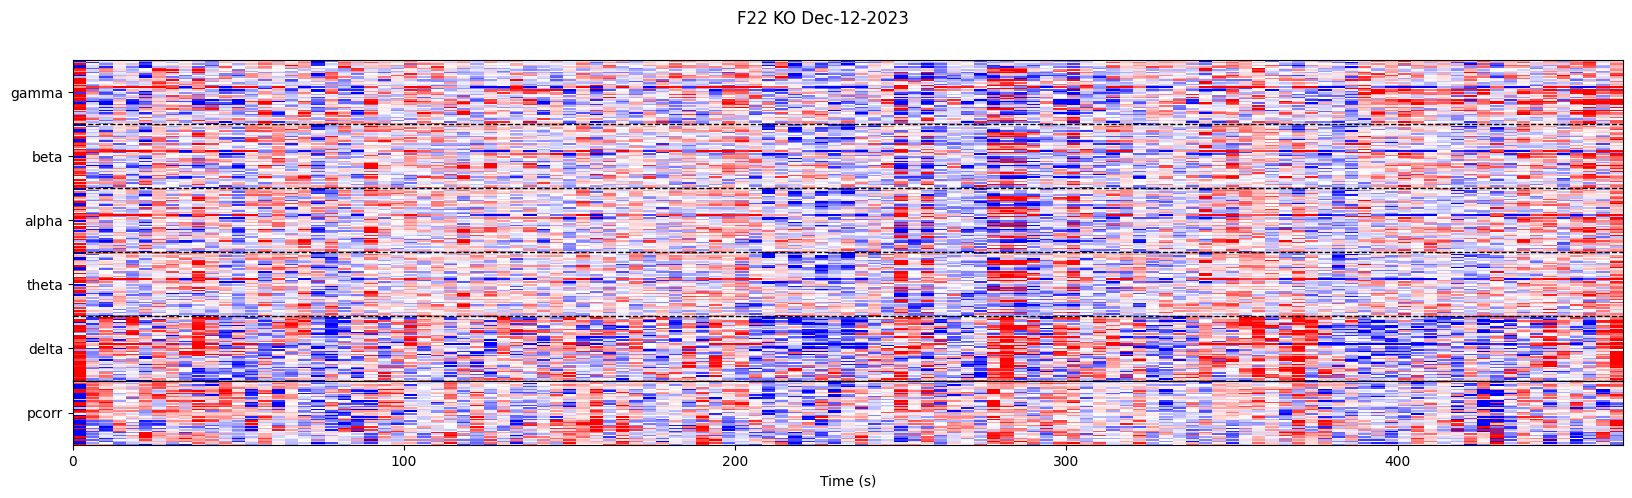

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/animal.py:325: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


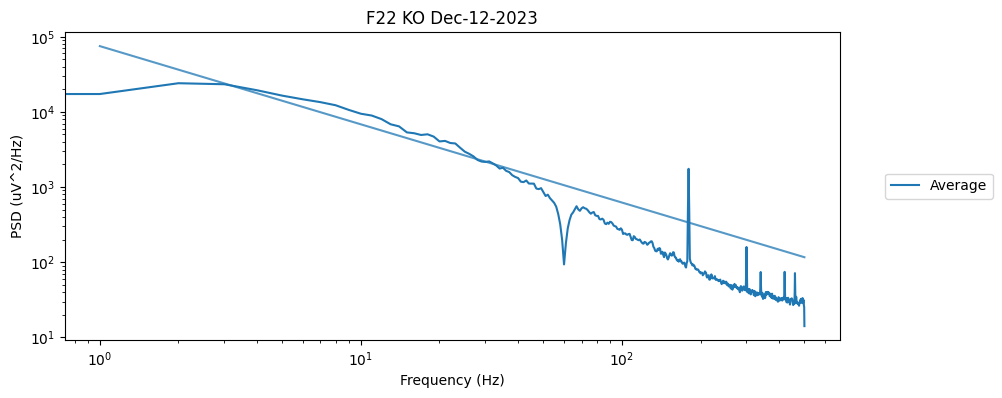

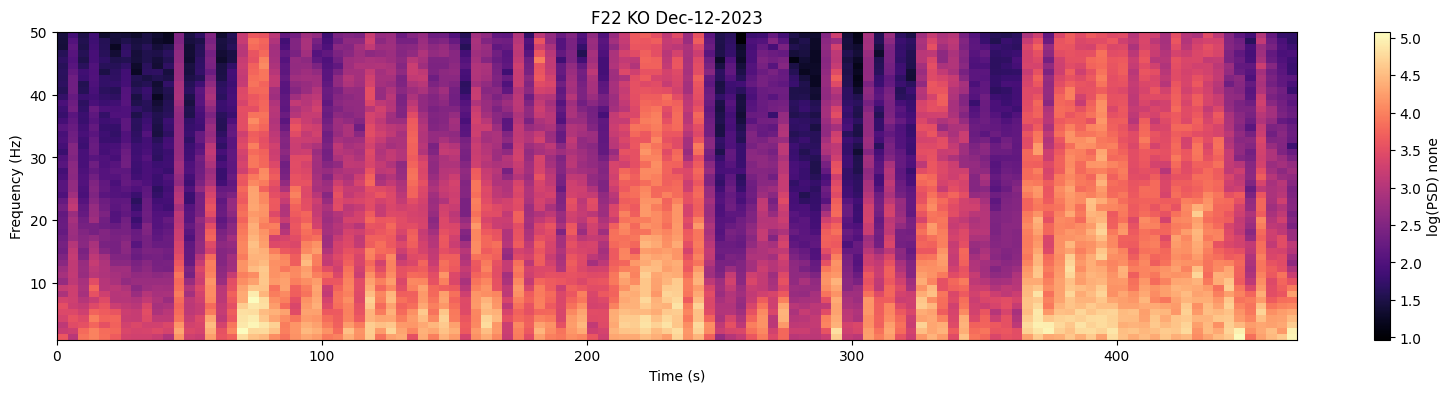

In [13]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [14]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-03-21 23:01:44,520 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,521 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,521 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,522 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,523 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,523 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,523 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-21 23:01:44,524 - WARNING - Intan

In [17]:
for feat in constants.LINEAR_FEATURE:
    logging.info(f'pulling {feat}')
    ep._pull_flat_dataframe(feat, ['genotype','animalday'])

2025-03-21 23:02:37,086 - INFO - pulling rms
2025-03-21 23:02:37,088 - DEBUG - channels: ['LAud', 'LBar', 'LHip', 'LMot', 'LVis', 'RAud', 'RBar', 'RHip', 'RMot', 'RVis']
2025-03-21 23:02:37,099 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-03-21 23:02:37,100 - DEBUG - vals.shape: (31, 10)
   genotype           animalday        LAud        LBar        LHip  \
0        KO  A10 KO Dec-13-2023   45.943722   72.767029   35.041542   
1        KO  A10 KO Dec-13-2023   17.386616   87.687950   17.702452   
2        KO  A10 KO Dec-13-2023   21.215885   85.188004   17.910995   
3        KO  A10 KO Dec-13-2023   16.124069   77.030235   14.081851   
4        KO  A10 KO Dec-13-2023   18.514677   86.265007   19.664534   
5        KO  A10 KO Dec-13-2023   23.877338   80.194534   23.737881   
6        KO  A10 KO Dec-13-2023   17.575144   84.014557   16.799391   
7        KO  A10 KO Dec-13-2023   18.340143   96.099640   15.620063   
8        KO  A10 KO Dec-13-2023  

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:

# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

In [ ]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

In [15]:
logger.setLevel(logging.DEBUG)

In [16]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

2025-03-21 21:23:27,956 - DEBUG - Converting channel 0 of 10
2025-03-21 21:23:27,957 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-21 21:23:27,966 - DEBUG - Converting channel 1 of 10
2025-03-21 21:23:27,966 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-21 21:23:27,972 - DEBUG - Converting channel 2 of 10
2025-03-21 21:23:27,973 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 470.16 KiB
2025-03-21 21:23:27,979 - DEBUG - Converting channel 3 of 10
2025-03-21 21:23:27,980 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


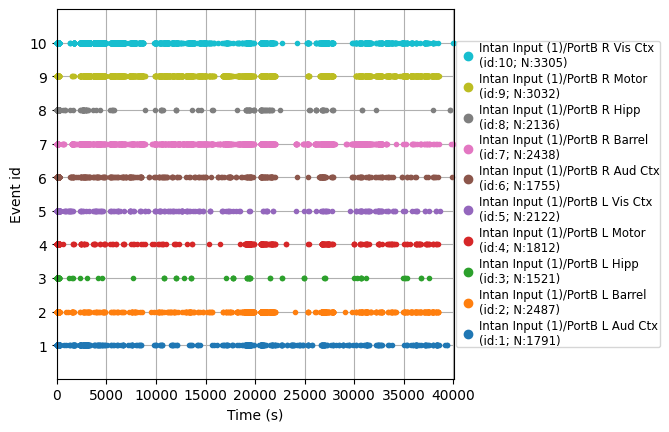

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)